In [1]:
import rtree
import json
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import torch
from PIL import Image
from torchvision.ops import box_convert




In [2]:
def load_coco_annotations(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


def using_rtree(annotations):
    rtree_idx = rtree.index.Index()
    non_overlapping_objects = []

    # Insert each bounding box into the R-tree
    for ann in annotations:
        bbox = ann['bbox']  # COCO bbox is [x, y, width, height]
        # Convert to [xmin, ymin, xmax, ymax]
        bbox_transformed = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        rtree_idx.insert(ann['id'], bbox_transformed)

    # Check for overlaps
    for ann in annotations:
        bbox = ann['bbox']
        bbox_transformed = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        if list(rtree_idx.intersection(bbox_transformed)) == [ann['id']]:
            non_overlapping_objects.append(ann)

    return non_overlapping_objects


def detect_non_overlapping(annotations):
    filtered_annotations = {}

    # Group annotations by image
    annotations_by_image = {}
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(annotation)

    # Process each image individually
    for image_id, anns in annotations_by_image.items():
        non_overlapping_objects = using_rtree(anns)
        filtered_annotations[image_id] = non_overlapping_objects

    return filtered_annotations


def remove_boundary_touching_bboxes(annotations, image_dimensions):
    """    
    Similar to detect_non_overlapping()
    Args:
        annotations: ...
        image_dimensions (dict): Dictionary where keys are image_ids and values are (width, height).
    Returns:
        dict: A dictionary with image IDs as keys and a list of filtered bounding boxes as values.
    """
    filtered_annotations = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        bbox = ann['bbox']  # bbox is [x, y, width, height]
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]
        image_width, image_height = image_dimensions[image_id]
        # Check if the bbox touches or crosses the image boundary
        if xmin <= 0 or ymin <= 0 or xmax >= image_width or ymax >= image_height:
            continue  # Exclude this bbox
        
        # Append to filtered annotations if not touching the boundary
        if image_id not in filtered_annotations:
            filtered_annotations[image_id] = []
        filtered_annotations[image_id].append(ann)

    return filtered_annotations


def intersect_annotations(ann1, ann2):
    """
    Assume ann1 and ann2 have the same image_ids.
    """
    output = {}
    for image_id in ann1.keys():
        set1 = set()
        set2 = set()
        if image_id in ann1:
            for object in ann1[image_id]:
                set1.add(object['id'])
        if image_id in ann2:
            for object in ann2[image_id]:
                set2.add(object['id'])
        intersection_id = set1.intersection(set2)
        intersection = []
        for object in ann1[image_id]:
            if  object['id'] in intersection_id:
                intersection.append(object)
        output[image_id] = intersection
    return output


def load_image_safely(original_filename, temp_filename='temp_image.png'):
    """
    Loads an image safely by copying it to a temporary file first.
    Args:
        original_filename (str): The path to the original image file.
        temp_filename (str): The path where the temporary file will be created.
    Returns:
        img (ndarray): Loaded image as a NumPy array, or None if loading failed.
    """
    try:
        # Copy the original file to a temporary file
        print(f'shutil.copy({original_filename}, {temp_filename})')
        shutil.copy(original_filename, temp_filename)

        # Load the image using OpenCV
        img = cv2.imread(temp_filename, 0)
        if img is not None:
            print("Image loaded successfully.")
        else:
            print("Failed to load image.")
        return img

    finally:
        # Ensure the temporary file is removed after use
        if os.path.exists(temp_filename):
            os.remove(temp_filename)


def get_image_id_dict(annotations):
    # Load COCO annotations only
    images = annotations['images']
    filename_to_id = {img['file_name']: img['id'] for img in images}

    return filename_to_id


def get_image_id_by_name(image_path, image_id_dict):
    filename = os.path.basename(image_path)
    image_id = image_id_dict.get(filename)
    if image_id is None:
        raise ValueError("No image ID found for the given filename.")
    return image_id


def get_bbox_from_coco(annotations):    # Dictionary to store bounding boxes for each image
    bbox_dict = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        if image_id not in bbox_dict:
            bbox_dict[image_id] = []
        # # Convert bbox to [x_min, y_min, x_max, y_max]
        # x_min, y_min, width, height = ann['bbox']
        # x_max = x_min + width
        # y_max = y_min + height
        # bbox_converted = [x_min, y_min, x_max, y_max]
        bbox_dict[image_id].append(ann['bbox'])
    return bbox_dict


def annotate_bbox_coco(image_source, boxes):
    if isinstance(boxes, list):
        boxes = torch.tensor(boxes)
    xyxy = box_convert(boxes=boxes, in_fmt="xywh", out_fmt="xyxy").numpy()
    detections = sv.Detections(xyxy=xyxy)
    detections.class_id = torch.zeros(len(boxes)).int()

    box_annotator = sv.BoxAnnotator()
    annotated_frame = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    # return detections
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    return annotated_frame


def get_image_dimensions_from_coco(annotations):
    image_dimensions = {}
    for img in annotations['images']:
        image_dimensions[img['id']] =(img['width'], img['height'])
    return image_dimensions


def get_info_bar_height(image):
    height_pixel = []
    for column in range(4): # check the first 4 column pixels
        bar_color = image[-1, column, 0]
        for pixel, color in enumerate(image[:, column, 0][::-1]):
            if color != bar_color:
                height_pixel.append(image.shape[0] - pixel - 1)
                break

    if np.array(height_pixel).std().astype(int) == 0:
        return height_pixel[0]
    else:
        raise ValueError("Failed to detect the information bar size.")


def adjust_image_dimensions(image_dimensions, bar_height, image_id=None):
    if image_id is not None:
        image_dimensions[image_id] = (image_dimensions[image_id][0], bar_height)
    else:
        for image_id, (width, height) in image_dimensions.items():
            image_dimensions[image_id] = (width, bar_height)
    return image_dimensions


def get_contours_from_mask(mask):
    mask = mask.int().squeeze().numpy().astype('uint8')
    _, thresh = cv2.threshold(mask, 0, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours

def plot_contours(image, contours):
    temp_image = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
    plt.figure()
    plt.imshow(temp_image)

def get_similarity_score(contour1, contour2):
    return cv2.matchShapes(contour1[0], contour2[0], 1, 0.0)

def compare_contours(mask1, mask2, image=None):
    contours1 = get_contours_from_mask(mask1)
    contours2 = get_contours_from_mask(mask2)
    if image is not None:
        plot_contours(image, contours1)
        plot_contours(image, contours2)
    return get_similarity_score(contours1, contours2)




In [35]:
annotations['info']

{'year': 2024,
 'version': '1.0',
 'description': 'Annotations in COCO format, labeled by DeepDataSpace',
 'contributor': '',
 'date_created': '2024-07-30T04:32:12.949Z'}

In [31]:
annotations['categories']

[{'id': 0, 'name': 'default'},
 {'id': 1, 'name': 'particle'},
 {'id': 2, 'name': 'p'}]

In [36]:
annotations_no_overlap

{0: [{'id': 49,
   'image_id': 0,
   'category_id': 1,
   'area': 18850,
   'bbox': [79, 68, 145.00000000000003, 129.99999999999997]},
  {'id': 61,
   'image_id': 0,
   'category_id': 1,
   'area': 4186.999999999999,
   'bbox': [365, 0, 78.99999999999999, 53]}],
 1: [{'id': 135,
   'image_id': 1,
   'category_id': 1,
   'area': 506.00000000000074,
   'bbox': [430, 38, 22.00000000000003, 23.000000000000004]},
  {'id': 136,
   'image_id': 1,
   'category_id': 1,
   'area': 624.0000000000033,
   'bbox': [568, 264, 26.000000000000057, 24.000000000000075]},
  {'id': 139,
   'image_id': 1,
   'category_id': 1,
   'area': 1722.0000000000011,
   'bbox': [305, 288.99999999999994, 42, 41.00000000000003]},
  {'id': 144,
   'image_id': 1,
   'category_id': 1,
   'area': 1296.0000000000014,
   'bbox': [133, 356, 36, 36.000000000000036]},
  {'id': 146,
   'image_id': 1,
   'category_id': 1,
   'area': 1891.999999999998,
   'bbox': [708, 428, 43.99999999999997, 42.99999999999998]}],
 2: [{'id': 152,


In [32]:
annotations['annotations']

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'area': 1019.999999999996,
  'bbox': [404.00000000000006, 357, 29.999999999999915, 33.999999999999964]},
 {'id': 1,
  'image_id': 0,
  'category_id': 1,
  'area': 11123.99999999999,
  'bbox': [576, 325, 107.99999999999991, 103]},
 {'id': 2,
  'image_id': 0,
  'category_id': 1,
  'area': 9300,
  'bbox': [136.00000000000003, 404, 99.99999999999999, 93.00000000000001]},
 {'id': 3,
  'image_id': 0,
  'category_id': 1,
  'area': 6479.999999999999,
  'bbox': [496, 389.00000000000006, 81, 79.99999999999999]},
 {'id': 4,
  'image_id': 0,
  'category_id': 1,
  'area': 780.0000000000002,
  'bbox': [329, 321, 38.99999999999996, 20.00000000000003]},
 {'id': 5,
  'image_id': 0,
  'category_id': 1,
  'area': 3740.0000000000014,
  'bbox': [151, 453, 85, 44.000000000000014]},
 {'id': 6,
  'image_id': 0,
  'category_id': 1,
  'area': 1643.0000000000002,
  'bbox': [304, 254.00000000000003, 31.00000000000003, 52.99999999999996]},
 {'id': 7,
  'image_id': 

In [3]:
from groundedsem import TrexM
from groundedsem.util.utils import load_model_hf, segment, draw_mask
from GroundingDINO.groundingdino.util.inference import annotate, load_image

# Define paths
# IMAGE_PATH = 'assets/2024-6-11-particles/pngs/2_1_5.00kV_0.17nA_108nm_101_ETD_1.00µs_yes_5000×.png'
IMAGE_PATH = 'assets/2024-6-11-particles/pngs/2_1_5.00kV_0.17nA_270nm_102_ETD_1.00µs_yes_2000×.png'
ANNOTATION_PATH = 'assets/2024-6-11-particles/pngs/Annotations_2024_7_30_0_32_12_950.json'

# Initialize TrexM
trexm = TrexM()

2024-08-02 00:04:04,774 - groundedsem.logging_config - INFO - Use default SAM. Downloading...
2024-08-02 00:04:04,775 - groundedsem.logging_config - INFO - SAM Done


c:\Users\fish\git_project\Grounded-SEM\groundedsem\core\sam_vit_h_4b8939.pth exists, skipping download.


In [4]:
# Load image
image_source, image_transed = load_image(IMAGE_PATH)

# Load annotations
annotations = load_coco_annotations(ANNOTATION_PATH)
image_id_dict =  get_image_id_dict(annotations)
image_id = get_image_id_by_name(IMAGE_PATH, image_id_dict)


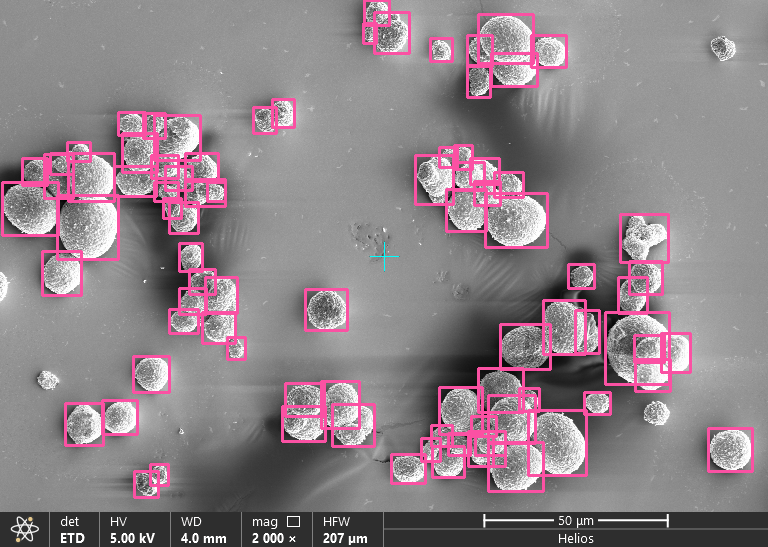

In [5]:
# Get bounding boxes for the image
bbox_dict = get_bbox_from_coco(annotations)
annotated_frame = annotate_bbox_coco(image_source, bbox_dict[image_id])
Image.fromarray(annotated_frame)

In [6]:
# post-process the image

# remove overlapping
annotations_no_overlap = detect_non_overlapping(annotations)

# remove boundary touching
image_dimensions = get_image_dimensions_from_coco(annotations)
bar_height_pixel = get_info_bar_height(image_source)
image_dimensions_adj = adjust_image_dimensions(image_dimensions, bar_height_pixel, image_id)
annotations_no_boundary = remove_boundary_touching_bboxes(annotations, image_dimensions_adj)

# merge all filters on annotations
ann_of_whole_particle = intersect_annotations(annotations_no_overlap, annotations_no_boundary)

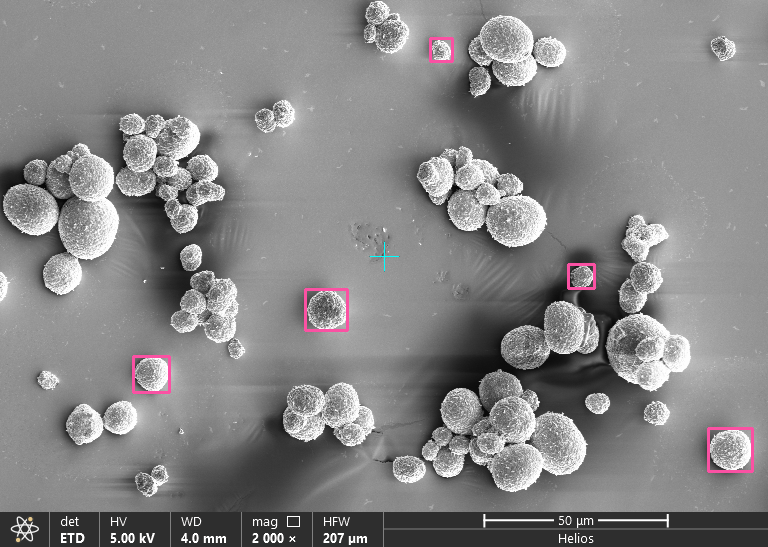

In [7]:
annotated_frame = annotate_bbox_coco(image_source, [object['bbox'] for object in ann_of_whole_particle[1]])
Image.fromarray(annotated_frame)


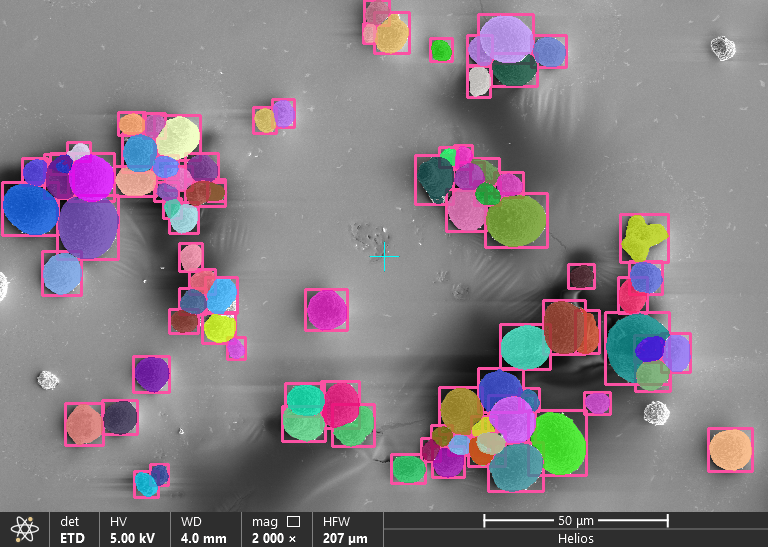

In [8]:
#SAM
segmented_masks = trexm.sam_segment(image_source, bbox_dict[image_id])

annotated_frame = annotate_bbox_coco(image_source, bbox_dict[image_id])
for mask in segmented_masks:
    annotated_frame = draw_mask(mask[0], annotated_frame)
Image.fromarray(annotated_frame)

0.2057336570096782

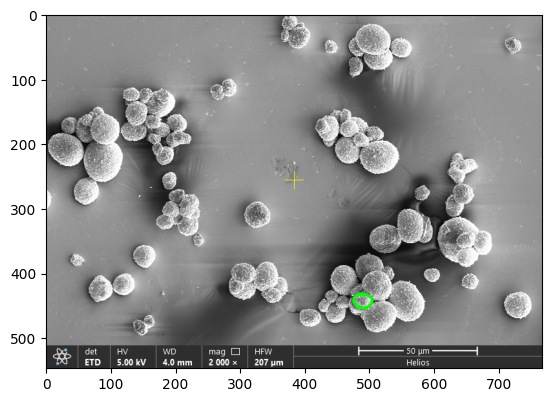

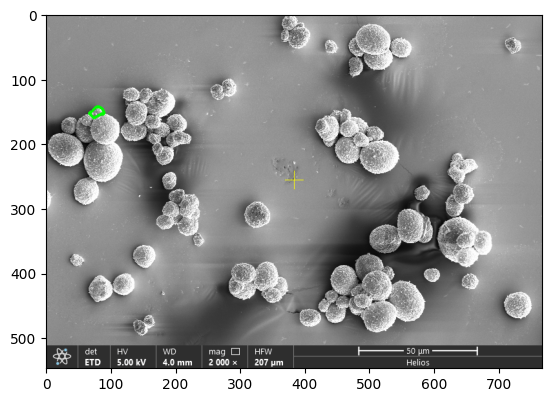

In [9]:
compare_contours(segmented_masks[10], segmented_masks[11], image_source)

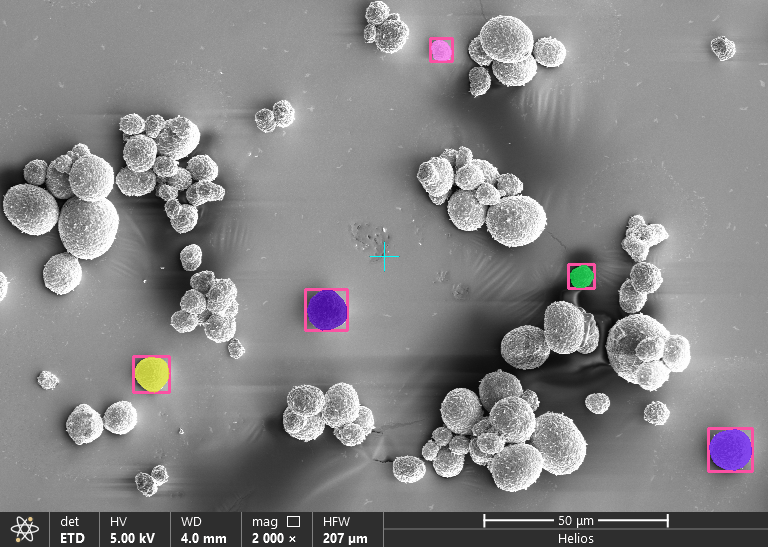

In [10]:
#SAM
segmented_masks_base = trexm.sam_segment(image_source, [object['bbox'] for object in ann_of_whole_particle[1]])

annotated_frame = annotate_bbox_coco(image_source, [object['bbox'] for object in ann_of_whole_particle[1]])
for mask in segmented_masks_base:
    annotated_frame = draw_mask(mask[0], annotated_frame)
Image.fromarray(annotated_frame)

0.018363545939916348

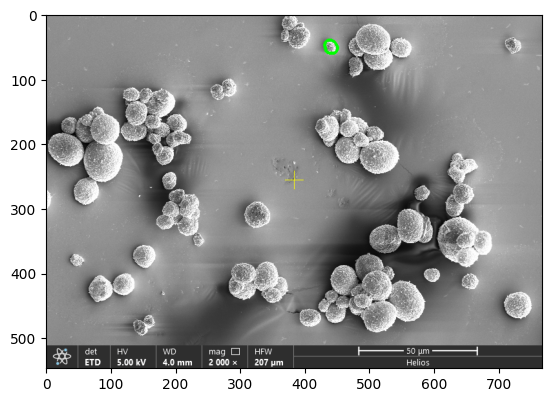

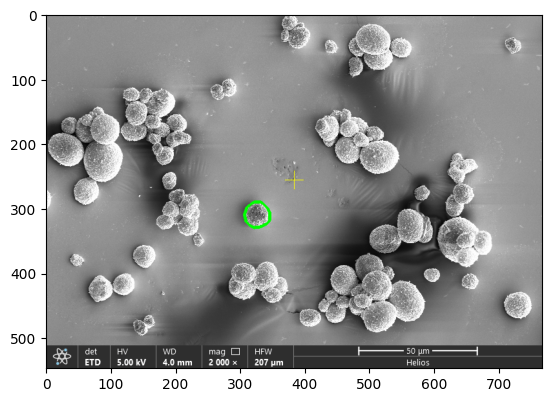

In [11]:
compare_contours(segmented_masks_base[0], segmented_masks_base[2], image_source)


In [12]:
base_similarity = []
for i, mask_1 in enumerate(segmented_masks_base):
    for mask_2 in segmented_masks_base[i+1:]:
        base_similarity.append(compare_contours(mask_1, mask_2))

In [13]:
k = 1 # hyperparameter. It means "the threshold is k times the standard deviation above the mean"
simi_thres = np.array(base_similarity).mean() + k * np.array(base_similarity).std()

In [14]:
def get_similar_masks(base_masks, masks, simi_thres):
    similar_masks = []
    for mask in masks:
        for base in base_masks:
            if compare_contours(base, mask) < simi_thres:
                similar_masks.append(mask)
                break
    return similar_masks

similar_masks = get_similar_masks(segmented_masks_base, segmented_masks, simi_thres)

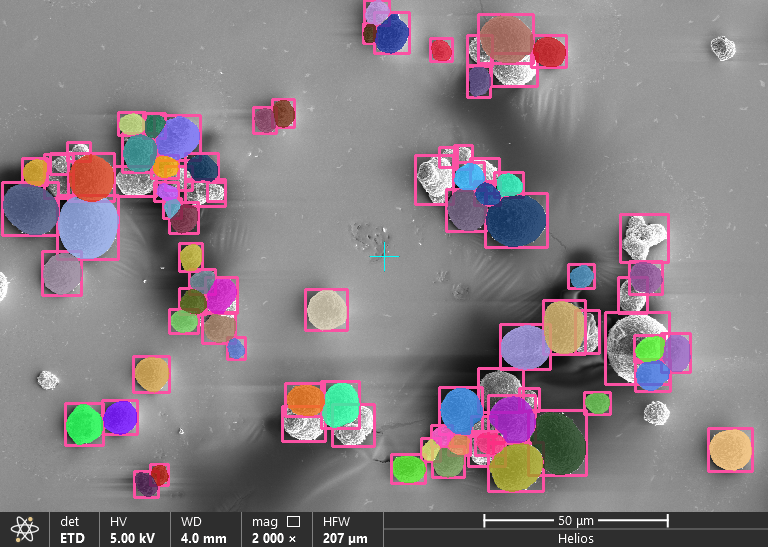

In [15]:
annotated_frame = annotate_bbox_coco(image_source, bbox_dict[image_id])

for mask in similar_masks:
    annotated_frame = draw_mask(mask[0], annotated_frame)
Image.fromarray(annotated_frame)
